## Imports and Preliminaries

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import timm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from scipy.spatial.distance import cosine
import timm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

Using device: cuda


## Dataset Class

In [2]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split="train", transform=None, cache=False):
        """
        Args:
            root_dir: Path to MVTec AD dataset root.
            category: Product category (e.g., 'bottle', 'cable', 'capsule').
            split: 'train' or 'test'.
            transform: torchvision transforms.
            cache: If True, images are pre-loaded into RAM for faster epochs.
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        self.cache = cache

        base_dir = self.root_dir / category / split

        if split == "train":
            img_dirs = [(base_dir / "good", 0, "good")]
        else:
            # Each folder inside 'test' is a defect type
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]

        self.image_paths = []
        self.labels = []
        self.defect_types = []

        for folder, lbl, defect in img_dirs:
            for img_path in sorted(folder.glob("*.png")):
                self.image_paths.append(img_path)
                self.labels.append(lbl)
                self.defect_types.append(defect)

        # Optional RAM caching
        self.cached_images = None
        if cache:
            self.cached_images = [
                Image.open(p).convert("RGB") for p in self.image_paths
            ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # if self.cache:
        #     img = self.cached_images[idx]
        # else:
        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        defect_type = self.defect_types[idx]

        return img, defect_type

## Create Datasets

In [4]:
from torch.utils.data import ConcatDataset
import os

MVTEC_ROOT = "../Dataset"
BATCH_SIZE = 40
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

root_dir = Path(MVTEC_ROOT)

all_categories = [cat.name for cat in root_dir.iterdir() if cat.is_dir()]
print(all_categories)


def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

transform = get_transforms(IMAGE_SIZE)

def build_concat(split):
    datasets = [
        MVTecDataset(MVTEC_ROOT, cat, split=split, transform=transform)
        for cat in all_categories
    ]
    return ConcatDataset(datasets)


train_dataset = build_concat("train")
test_dataset = build_concat("test")

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


TRAINING IMAGES


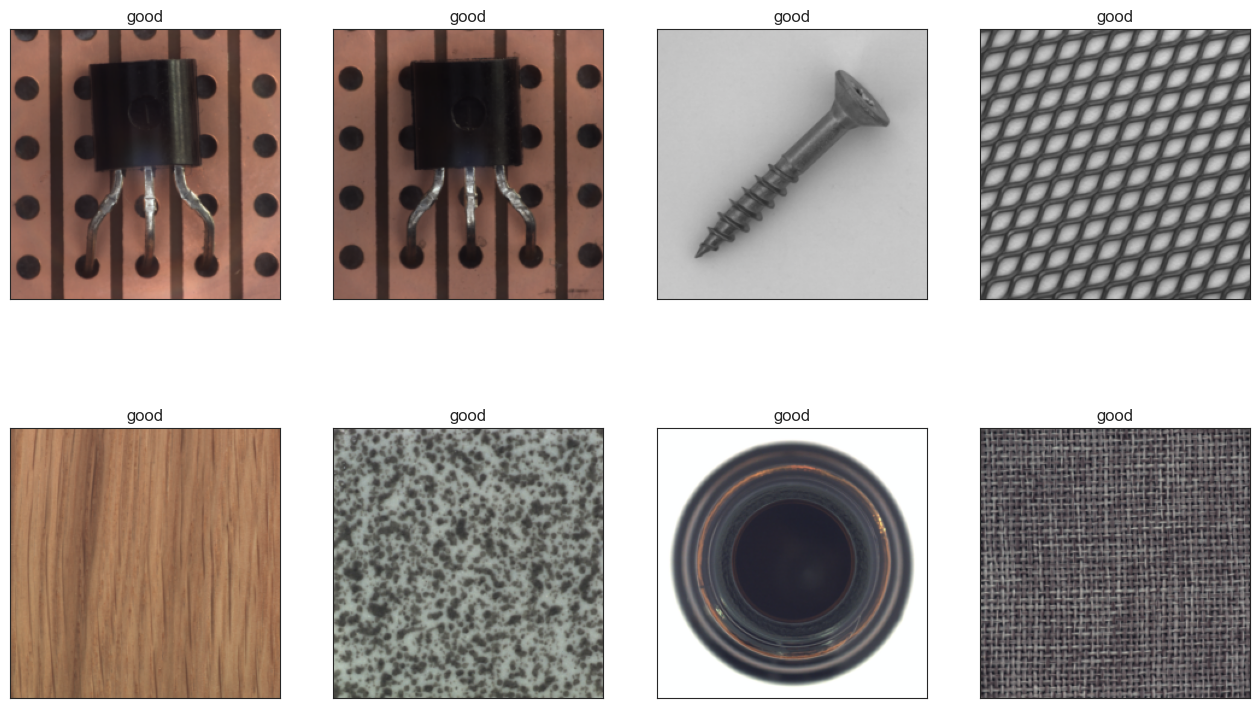

TESTING IMAGES


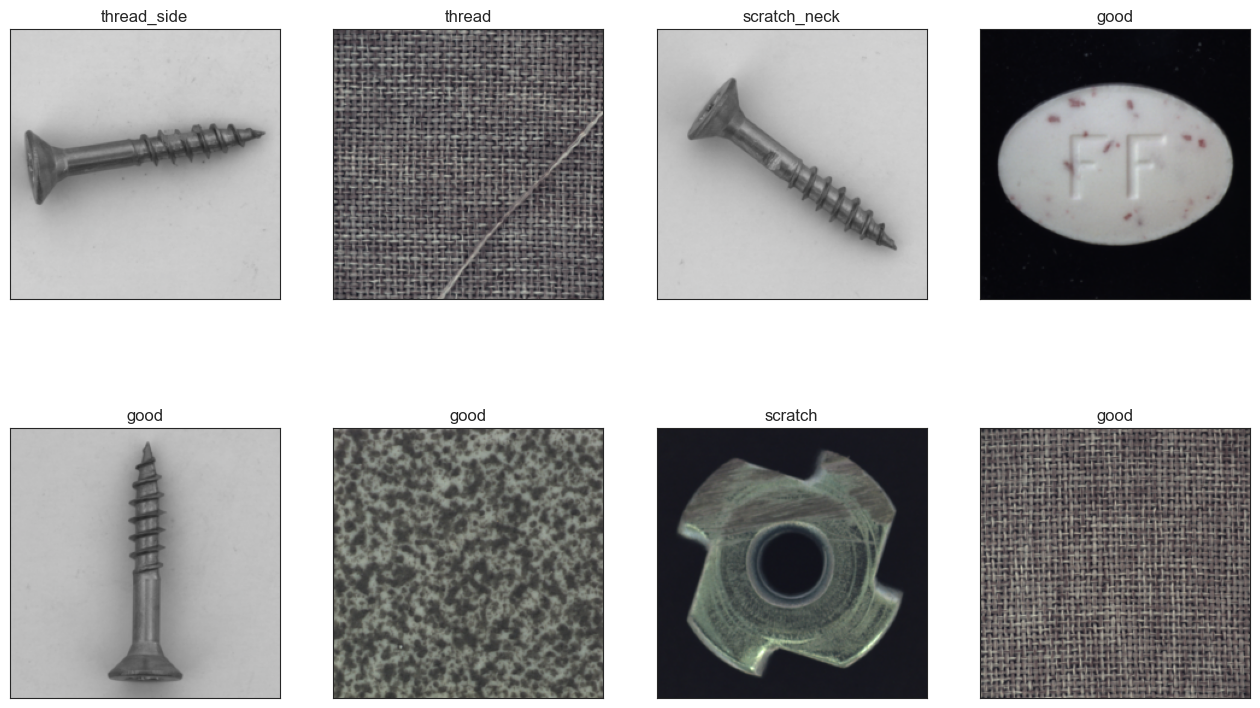

In [5]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))

    with sns.axes_style("white"):
        fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))

    axes = [ax for row in axes for ax in row]

    for j, ax in enumerate(axes[:8]):
        img = images[j]
        label = labels[j]

        plt.sca(ax)
        show_image(img, label)

    plt.show()


train_example_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

test_example_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)

print("TRAINING IMAGES")
show_dataset_examples(train_example_loader)
print("TESTING IMAGES")
show_dataset_examples(test_example_loader)

## Embed training features, compare to Test data and draw conclusion

In [6]:
EMBEDDING_FILE_EXT = "embeddings.npz"

def save_embeddings_compressed(embeddings, save_path="./embeddings", dataset_name="train"):
    """
    Args:
        embeddings: List of (embedding, label) tuples
        save_path: Directory to save files
        dataset_name: Base name for the files
    """
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    # Separate embeddings and labels
    emb_arrays = np.array([emb for emb, _ in embeddings])
    labels = np.array([label for _, label in embeddings])

    # Save as compressed numpy
    npz_path = save_path / f"{dataset_name}_{EMBEDDING_FILE_EXT}"
    np.savez_compressed(npz_path, embeddings=emb_arrays, labels=labels)

    print(f"✓ Compressed embeddings saved to: {npz_path}")
    print(f"  File size: {os.path.getsize(npz_path) / 1e6:.2f} MB")

    return npz_path


def load_embeddings_compressed(npz_path):
    """
    Load embeddings from compressed numpy format.

    Args:
        npz_path: Path to .npz file

    Returns:
        embeddings: List of (embedding_array, label) tuples
    """
    print(f"Loading compressed embeddings from: {npz_path}")

    data = np.load(npz_path)
    emb_arrays = data["embeddings"]
    labels = data["labels"]

    # Convert to list of tuples
    embeddings = [(emb_arrays[i], labels[i]) for i in range(len(labels))]

    print(f"✓ Loaded {len(embeddings)} embeddings")

    return embeddings

In [7]:
def embed_and_save_features(
    dataloader, split, model_url="vit_small_patch16_dinov3_qkvb.lvd1689m", device=None
):
    """
    Efficient, stable DINOv3 patch embedding extractor.
    Uses mean pooling over patch tokens → 384-dim embeddings.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
    
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):

            images = images.to(device)

            feats = model.forward_features(images)

            # ---- PATCH TOKEN EXTRACTION (best for accuracy) ----
            if isinstance(feats, dict):
                x = feats.get("x_norm")  # (B, num_patches, 384)
            else:
                x = feats  # fallback

            # ---- MEAN POOL OVER PATCHES (optimal) ----
            emb = x.mean(dim=1)  # (B, 384)

            emb = emb.cpu().numpy()

            for i, label in enumerate(labels):
                lbl = label.item() if isinstance(label, torch.Tensor) else label
                embeddings.append((emb[i], lbl))

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx+1} batches")

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split)
    return embeddings

In [7]:
embedding_folder = "./embeddings"
train_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
embeddings_GT = (
    load_embeddings_compressed(train_path)
    if os.path.exists(train_path)
    else embed_and_save_features(train_loader, "train")
)
    
print(len(embeddings_GT))


Using device: cpu
Processed 10 batches
Processed 20 batches
Processed 30 batches
Processed 40 batches
Processed 50 batches
Processed 60 batches
Processed 70 batches
Processed 80 batches
Processed 90 batches
✓ Compressed embeddings saved to: embeddings\train_embeddings.npz
  File size: 5.17 MB
3629


In [13]:
# EMBED TEST DATATSET
embedding_folder = "./embeddings"
test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"
embeddings_test = (
    load_embeddings_compressed(test_path)
    if os.path.exists(test_path)
    else embed_and_save_features(test_loader, "test")
)
    
print(len(embeddings_test))

Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
1725


In [ ]:
print(embeddings_GT[0][0].shape)

GMM Fitting

In [14]:
from sklearn.mixture import GaussianMixture

K = 15

def fit_gmm(K: int = 15):
    embedding_folder = "./embeddings"
    train_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
    embeddings_GT = (
        load_embeddings_compressed(train_path)
        if os.path.exists(train_path)
        else embed_and_save_features(train_loader, "train")
    )

    # Extract embeddings and flatten each one (in case they're matrices)
    flattened_embeddings = []
    for emb, _ in embeddings_GT:
        flat_emb = emb.flatten()
        flattened_embeddings.append(flat_emb)

    # Stack into a matrix: (n_samples, n_features)
    X = np.array(flattened_embeddings)

    # Fit the GMM
    gmm = GaussianMixture(n_components=K, covariance_type='full')
    gmm.fit(X)

    print(f"✓ GMM fitted with K={K} components on {len(X)} samples with {X.shape[1]} features")

    return gmm

CLASSIFIER

In [15]:
def classify_with_gmm(gmm, threshold=-50, embedding_folder="./embeddings"):
    """
    Classify test data using GMM with log-likelihood threshold.
    
    Since GMM is trained only on good images:
    - High log-likelihood = sample fits GMM well = GOOD
    - Low log-likelihood = sample doesn't fit GMM = ANOMALOUS
    
    Args:
        gmm: Fitted GaussianMixture model
        threshold: Log-likelihood threshold for classification
                   (samples with LL > threshold are classified as GOOD)
        embedding_folder: Path to embeddings folder
    
    Returns:
        tuple: (accuracy, precision, recall, f1, predictions, ll_scores, true_labels)
    """
    test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"
    
    embeddings_Test = (
        load_embeddings_compressed(test_path)
        if os.path.exists(test_path)
        else embed_and_save_features(test_loader, "test")
    )
    
    # Extract and flatten test embeddings
    flattened_test = []
    test_labels = []
    for emb, label in embeddings_Test:
        flat_emb = emb.flatten()
        flattened_test.append(flat_emb)
        test_labels.append(label)
    
    X_test = np.array(flattened_test)
    
    # Calculate log-likelihood
    ll_scores = gmm.score_samples(X_test)  # Log-likelihood
    
    # Classify based on threshold
    # LL > threshold → GOOD (0), LL ≤ threshold → ANOMALOUS (1)
    predictions = np.where(ll_scores > threshold, 0, 1)
    
    # Convert labels to binary (0="good", 1="anomalous")
    true_labels = np.array([0 if str(label).lower() == "good" else 1 for label in test_labels])
    
    # Calculate metrics
    accuracy = (predictions == true_labels).mean()
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    
    print(f"✓ Classification using GMM:")
    print(f"  Threshold (LL): {threshold:.4f}")
    print(f"  Accuracy:  {accuracy*100:.2f}% ({(predictions == true_labels).sum()}/{len(true_labels)})")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  F1 Score:  {f1*100:.2f}%")
    print(f"  LL Score Range: [{ll_scores.min():.4f}, {ll_scores.max():.4f}]")
    
    return accuracy, precision, recall, f1, predictions, ll_scores, true_labels

MAIN

In [ ]:
# Fit GMM and classify test data
gmm_model = fit_gmm(K=15)

# Get log-likelihood scores to find optimal threshold
embedding_folder = "./embeddings"
test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"
embeddings_Test = load_embeddings_compressed(test_path)

flattened_test = []
for emb, _ in embeddings_Test:
    flattened_test.append(emb.flatten())
X_test = np.array(flattened_test)

ll_scores = gmm_model.score_samples(X_test)

# Test different thresholds to find optimal one
print("\n" + "="*60)
print("Testing different Log-Likelihood thresholds:")
print("="*60)

# Test thresholds across the range of log-likelihoods
thresholds = np.linspace(ll_scores.min(), ll_scores.max(), 3)
best_acc = 0
best_threshold = ll_scores.mean()

for thresh in thresholds:
    acc, _, _, _, _, _, _ = classify_with_gmm(gmm_model, threshold=thresh)
    if acc > best_acc:
        best_acc = acc
        best_threshold = thresh

print(f"\n✓ Best threshold: {best_threshold:.4f} with accuracy: {best_acc*100:.2f}%")

# Final classification with best threshold
print("\n" + "="*60)
print("Final Classification Results:")
print("="*60)
acc, prec, rec, f1, preds, ll_scores, true_labels = classify_with_gmm(gmm_model, threshold=best_threshold)

Loading compressed embeddings from: ./embeddings/train_embeddings.npz
✓ Loaded 3629 embeddings
✓ GMM fitted with K=15 components on 3629 samples with 384 features
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings

Testing different Log-Likelihood thresholds:
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
✓ Classification using GMM:
  Threshold (LL): -524029.1815
  Accuracy:  27.13% (468/1725)
  Precision: 100.00%
  Recall:    0.08%
  F1 Score:  0.16%
  LL Score Range: [-524029.1815, 55.4802]
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
✓ Classification using GMM:
  Threshold (LL): -261986.8507
  Accuracy:  31.25% (539/1725)
  Precision: 98.65%
  Recall:    5.80%
  F1 Score:  10.96%
  LL Score Range: [-524029.1815, 55.4802]
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
✓ Classification using GMM:
  Thr

HYPERPARAMETER OPTIMIZATION

In [28]:
import optuna
from optuna.samplers import TPESampler

# Fit GMM
gmm_model = fit_gmm(K=15)

# Load test embeddings once for all trials
embedding_folder = "./embeddings"
test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"
embeddings_Test = load_embeddings_compressed(test_path)

flattened_test = []
test_labels = []
for emb, label in embeddings_Test:
    flattened_test.append(emb.flatten())
    test_labels.append(label)

X_test = np.array(flattened_test)
ll_scores = gmm_model.score_samples(X_test)
true_labels = np.array([0 if str(label).lower() == "good" else 1 for label in test_labels])

# Determine search range for threshold
# Handle negative and positive values separately for log search
ll_min, ll_max = ll_scores.min(), ll_scores.max()

ll_min = -5000  # ADJUSTED MINMUM FOR BETTER SEARCH

print(f"LL Score Range: [{ll_min:.2f}, {ll_max:.2f}]")

# Define objective function for Optuna - optimize for F1 score from classifier
def objective(trial):
    """
    Objective function to maximize F1 score by tuning the threshold.
    Uses the classifier's computed F1 score.
    Employs log-scale search for efficient exploration of the wide range.
    """
    # For negative values, use log scale on absolute value, then negate
    if ll_min < 0 and ll_max > 0:
        # Mix of negative and positive - use log search in chunks
        # Suggest threshold with log scale to handle large range efficiently
        threshold = trial.suggest_float("threshold", ll_min, ll_max, log=False)
    else:
        threshold = trial.suggest_float("threshold", ll_min, ll_max)
    
    # Classify based on threshold and get metrics
    accuracy, precision, recall, f1, predictions, _, _ = classify_with_gmm(
        gmm_model, threshold=threshold, embedding_folder=embedding_folder
    )
    
    # Return F1 score for optimization
    return f1

# Create study and optimize
print("="*60)
print("Starting Optuna Hyperparameter Optimization")
print("Optimizing: F1 Score")
print(f"Search range: [{ll_min:.2f}, {ll_max:.2f}]")
print("="*60)

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Get best trial
best_trial = study.best_trial
best_threshold = best_trial.params["threshold"]
best_f1 = best_trial.value

print("\n" + "="*60)
print("Optimization Results:")
print("="*60)
print(f"✓ Best Threshold: {best_threshold:.6f}")
print(f"✓ Best F1 Score: {best_f1*100:.2f}%")
print(f"✓ Number of Trials: {len(study.trials)}")

# Final classification with best threshold
print("\n" + "="*60)
print("Final Classification with Best Threshold:")
print("="*60)
acc, prec, rec, f1, preds, _, _ = classify_with_gmm(gmm_model, threshold=best_threshold)

Loading compressed embeddings from: ./embeddings/train_embeddings.npz
✓ Loaded 3629 embeddings
✓ GMM fitted with K=15 components on 3629 samples with 384 features
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings


[I 2025-11-30 17:27:34,692] A new study created in memory with name: no-name-24efc67a-8438-4be9-b14b-86d75672d828


LL Score Range: [-5000.00, 55.48]
Starting Optuna Hyperparameter Optimization
Optimizing: F1 Score
Search range: [-5000.00, 55.48]


  0%|          | 0/100 [00:00<?, ?it/s]

Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
✓ Classification using GMM:
  Threshold (LL): -3106.5199
  Accuracy:  75.13% (1296/1725)
  Precision: 76.09%
  Recall:    96.10%
  F1 Score:  84.93%
  LL Score Range: [-407359.6750, 55.4802]
[I 2025-11-30 17:27:35,102] Trial 0 finished with value: 0.8493150684931506 and parameters: {'threshold': -3106.5198524940997}. Best is trial 0 with value: 0.8493150684931506.
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
✓ Classification using GMM:
  Threshold (LL): -193.6827
  Accuracy:  72.99% (1259/1725)
  Precision: 72.97%
  Recall:    100.00%
  F1 Score:  84.37%
  LL Score Range: [-407359.6750, 55.4802]
[I 2025-11-30 17:27:35,477] Trial 1 finished with value: 0.8437290409121395 and parameters: {'threshold': -193.68266695445163}. Best is trial 0 with value: 0.8493150684931506.
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 

HYPERPARAM OPTIMIZATION ANALYSIS

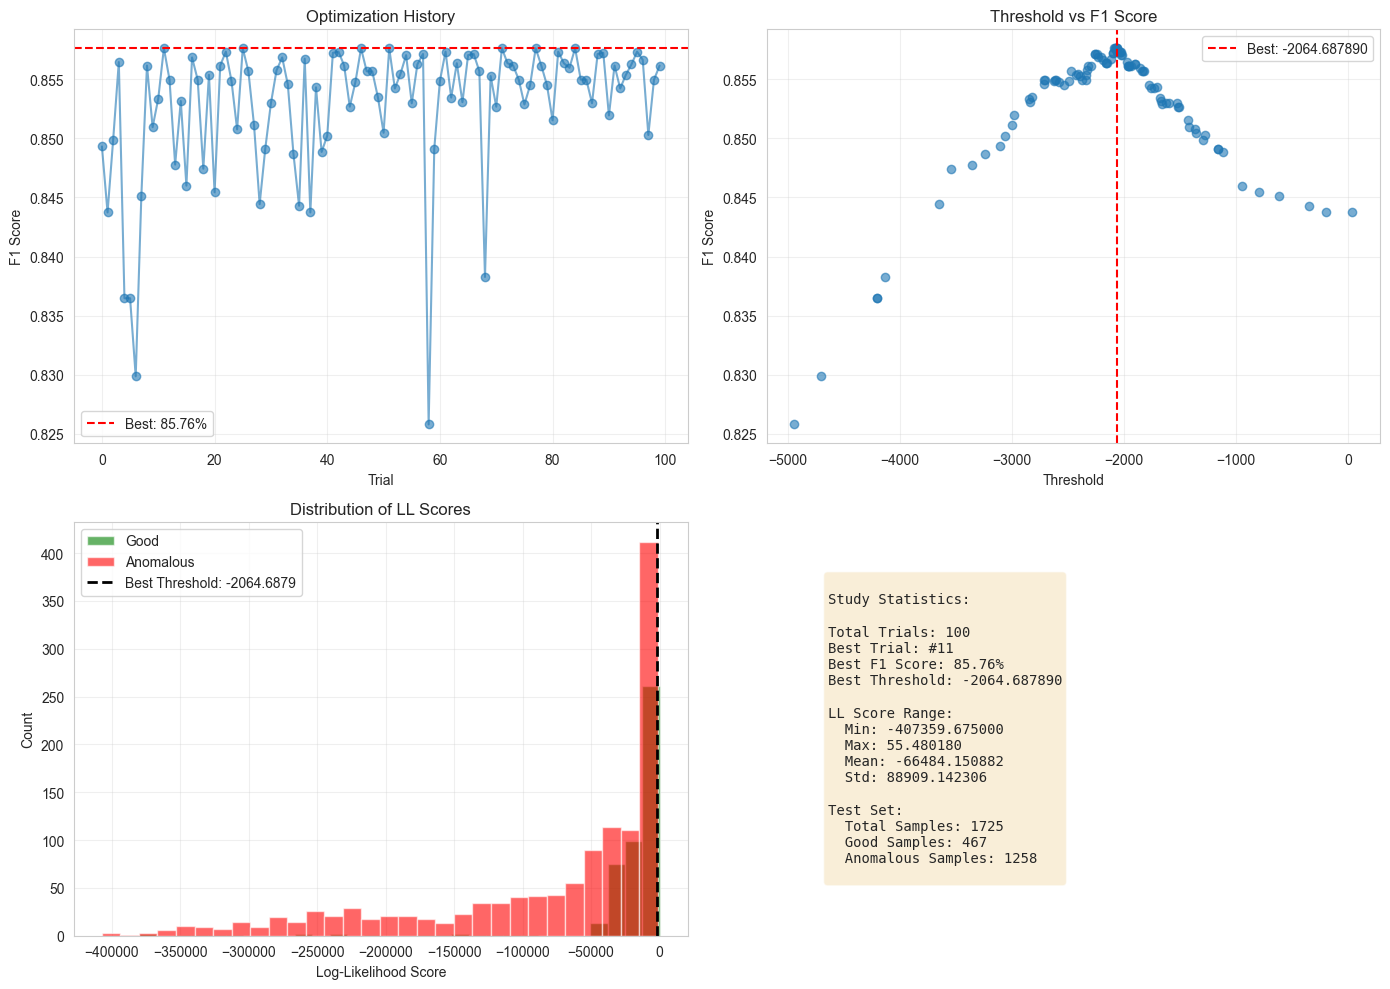

✓ Visualization complete


In [29]:
# Visualize optimization history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Optimization History
ax = axes[0, 0]
trials_df = study.trials_dataframe()
ax.plot(trials_df.index, trials_df['value'], 'o-', alpha=0.6)
ax.axhline(y=best_f1, color='r', linestyle='--', label=f'Best: {best_f1*100:.2f}%')
ax.set_xlabel('Trial')
ax.set_ylabel('F1 Score')
ax.set_title('Optimization History')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Threshold vs F1 Score
ax = axes[0, 1]
thresholds_tested = [t.params['threshold'] for t in study.trials]
accuracies = [t.value for t in study.trials]
ax.scatter(thresholds_tested, accuracies, alpha=0.6)
ax.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best: {best_threshold:.6f}')
ax.set_xlabel('Threshold')
ax.set_ylabel('F1 Score')
ax.set_title('Threshold vs F1 Score')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Log-Likelihood Distribution
ax = axes[1, 0]
good_mask = true_labels == 0
anomalous_mask = true_labels == 1
ax.hist(ll_scores[good_mask], bins=30, alpha=0.6, label='Good', color='green')
ax.hist(ll_scores[anomalous_mask], bins=30, alpha=0.6, label='Anomalous', color='red')
ax.axvline(x=best_threshold, color='black', linestyle='--', linewidth=2, label=f'Best Threshold: {best_threshold:.4f}')
ax.set_xlabel('Log-Likelihood Score')
ax.set_ylabel('Count')
ax.set_title('Distribution of LL Scores')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Study Statistics
ax = axes[1, 1]
ax.axis('off')
stats_text = f"""
Study Statistics:

Total Trials: {len(study.trials)}
Best Trial: #{best_trial.number}
Best F1 Score: {best_f1*100:.2f}%
Best Threshold: {best_threshold:.6f}

LL Score Range:
  Min: {ll_scores.min():.6f}
  Max: {ll_scores.max():.6f}
  Mean: {ll_scores.mean():.6f}
  Std: {ll_scores.std():.6f}

Test Set:
  Total Samples: {len(true_labels)}
  Good Samples: {(true_labels == 0).sum()}
  Anomalous Samples: {(true_labels == 1).sum()}
"""
ax.text(0.1, 0.5, stats_text, fontsize=10, family='monospace', 
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

In [33]:
# Fit GMM and classify test data
gmm_model = fit_gmm(K=15)

# Get log-likelihood scores to find optimal threshold
embedding_folder = "./embeddings"
test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"
embeddings_Test = load_embeddings_compressed(test_path)

flattened_test = []
for emb, _ in embeddings_Test:
    flattened_test.append(emb.flatten())
X_test = np.array(flattened_test)

ll_scores = gmm_model.score_samples(X_test)

acc, prec, rec, f1, preds, _, _ = classify_with_gmm(gmm_model, threshold=0)


# Print metrics
print(f"\nFinal Metrics at threshold 0:")
print(f"Accuracy:  {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall:    {rec*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")


Loading compressed embeddings from: ./embeddings/train_embeddings.npz
✓ Loaded 3629 embeddings
✓ GMM fitted with K=15 components on 3629 samples with 384 features
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
✓ Classification using GMM:
  Threshold (LL): 0.0000
  Accuracy:  72.99% (1259/1725)
  Precision: 72.97%
  Recall:    100.00%
  F1 Score:  84.37%
  LL Score Range: [-392863.0170, 55.4802]

Final Metrics at threshold 0:
Accuracy:  72.99%
Precision: 72.97%
Recall:    100.00%
F1 Score:  84.37%
